In [1]:
# Render our plots inline
%matplotlib inline
%pylab inline  
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# General Plotting Parameters
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 14.
mpl.rcParams['legend.fontsize'] = 12.
mpl.rcParams['axes.labelsize'] = 12.
mpl.rcParams['xtick.labelsize'] = 10.
mpl.rcParams['ytick.labelsize'] = 10.
mpl.rcParams['xtick.minor.pad'] = 4
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

#Git says this is patched, but it doesn't work from Pip --upgrade 26-mar-2015
#mpl.rcParams['xtick.minor.visible'] = True  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
             (255, 187, 120), (44, 160, 44), (152, 223, 138),
              (148, 103, 189),
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127),
             (199, 199, 199), (188, 189, 34), (219, 219, 141),
             (23, 190, 207), (158, 218, 229),(214, 39, 40), (255, 152, 150)]  
    
# Scale the RGB values to the [0, 1] range,
# which is the format matplotlib accepts.  
for i in range(len(tableau20)): 
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

Populating the interactive namespace from numpy and matplotlib


In [2]:
import calc_enrich
reload(calc_enrich)
from calc_enrich import calc_del_U
from calc_enrich import stages_per_cascade
from calc_enrich import N_product_by_alpha
from calc_enrich import N_waste_by_alpha
from calc_enrich import machines_per_enr_stage
from calc_enrich import machines_per_strip_stage
from calc_enrich import product_per_enr_stage
from calc_enrich import waste_per_strip_stage
from calc_enrich import Npc_from_Nstages
from calc_enrich import Nwc_from_Nstages
from calc_enrich import machines_per_cascade
from calc_enrich import allowed_feed_per_stage

For a type of centrifuge and some cascade guidelines, design the cascade
Start at nat U, enrich to 3.5%, 
Use IR-1 machines (Inst Sci Intl Security, IAEA 2014)

In [3]:
# centrifuge params 
#omega = 64000
#d = 0.1  # m 
#Z = 2.0   # m
#F_m_hrs = 70 # grams/hr  
#T = 320.0   # K
#cut = 0.5
eff = 1.0 # centrifuge efficiency

d = 0.15  # m 
Z = 1.0   # m
F_m_hrs = 15*60*60/(1e3) # grams/hr  
T = 320.0# K
cut = 0.5
omega = 485/(d/2)

# cascade params
Nfc = 0.0071
Npc = 0.035
#Nwc = 0.001
Fc_month = 739 #kg/month

# The feed enrichment to be used when using a cascade designed for LEU to produce HEU.
Nfc_mod = 0.20
Fc_month_mod = 46 #kg/month

#unit conversions
v_a = omega * (d/2.0)
F_m = F_m_hrs/(60*60*1000.0)
Fc = Fc_month/(30.4*24*60*60)
Fc_mod = Fc_month_mod/(30.4*24*60*60)


# Comparison numbers (not needed for calculations)
del_U_th_yr = 1.1 #swu/yr
del_U_obs_yr = 0.71 #Swu/yr
del_U_th = del_U_th_yr/(365.25*24*60*60) #kgSWU/sec
del_U_obs = del_U_obs_yr/(365.25*24*60*60)

Pc_month = 77 #kg/month
Pc = Pc_month/(30.4*24*60*60)


In [4]:
alpha, del_U, del_U_yr = calc_del_U(v_a, Z, d, F_m, T, cut, eff)
print "del_U is", del_U, " alpha is ", alpha
#n_enrich_s, n_strip_s= stages_per_cascade(alpha, Nfc, Npc, Nwc)
#print "number of enrich, strip stages is ", n_enrich_s, n_strip_s, alpha
#print del_U*60*60*24*365.25, del_U_th

#n_cf = machines_per_cascade(del_U, Npc, Nwc, Fc, Pc)
#print "number machines per cascade ideal", n_cf

del_U is 3.1939942861e-07  alpha is  1.34782845204


In [5]:
# Calculate the desired number of enrichment stages and machines per stage by ending
# the stages when there is less than an integer machine
Nfs = Nfc
Fs = Fc

enrich_stages = []
int_stages = True
n_stage_enr = 0
print "stage, #mach, Feed,   Product,    N_F,     N_P"
while (int_stages == True):
    n_mach_enr = machines_per_enr_stage(alpha, del_U, Fs)
    if (int(n_mach_enr) <= 1):
        int_stages = False
    Nps = N_product_by_alpha(alpha, Nfs)
    Ps = product_per_enr_stage(alpha, Nfs, Nps, Fs)
    enrich_stages.append([n_stage_enr, n_mach_enr])
    if (n_stage_enr == 1):
        W_enr1 = Fs - Ps
        Nw_enr1 = (Fs*Nfs - Ps*Nps)/W_enr1
    print n_stage_enr, n_mach_enr, Fs, Ps,  Nfs, Nps
    Nfs = Nps
    Fs = Ps
    n_stage_enr+=1


stage, #mach, Feed,   Product,    N_F,     N_P
0 53.2872354761 0.000281356603314 0.00014102571826 0.0071 0.00954600736145
1 26.7094163371 0.00014102571826 7.0746988121e-05 0.00954600736145 0.0128238005246
2 13.3990507805 7.0746988121e-05 3.55312769183e-05 0.0128238005246 0.0172075293237
3 6.72940850725 3.55312769183e-05 1.78719705716e-05 0.0172075293237 0.0230548083983
4 3.38484291129 1.78719705716e-05 9.0076440091e-06 0.0230548083983 0.0308267235719
5 1.70599318354 9.0076440091e-06 4.55211383759e-06 0.0308267235719 0.0411083544195


In [6]:
epsilon = alpha - 1.0
F_strip = W_enr1
Nf_strip = Nw_enr1

# Consider the zeroth stage of cascade to be on enrich side (iterate from 0), 
# then iterate from 1 for strip side
print "stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
int_stages = True
n_stage_str = 1
while (int_stages == True):
    n_mach_s= machines_per_strip_stage(alpha, del_U, F_strip)
    if (int(n_mach_s) <= 1):
        int_stages = False
    Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
    W_strip = waste_per_strip_stage(alpha, Nf_strip, Nw_strip, F_strip)
    strip_stages.append([-1*n_stage_str,n_mach_s])
    print n_stage_str, n_mach_s, F_strip, W_strip, Nf_strip, Nw_strip
    F_strip = W_strip
    Nf_strip = Nw_strip
    n_stage_str+=1

print "waste of cascade (kg/mon)" , W_strip*60*60*24*30
print "Feed for strip ", F_strip

stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip
1 13.3103655566 7.02787301389e-05 4.7285489894e-05 0.00624637469139 0.00464188149755
2 8.95558520719 4.7285489894e-05 3.18281912573e-05 0.00464188149755 0.00344810106969
3 6.028066526 3.18281912573e-05 2.14303843435e-05 0.00344810106969 0.00256054251202
4 4.05878491353 2.14303843435e-05 1.44326976115e-05 0.00256054251202 0.00190101017971
5 2.73346545672 1.44326976115e-05 9.7216286069e-06 0.00190101017971 0.00141111670635
6 1.84121753919 9.7216286069e-06 6.54915800161e-06 0.00141111670635 0.0010473371185
waste of cascade (kg/mon) 16.9754175402
Feed for strip  6.54915800161e-06


/Users/mbmcgarry/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


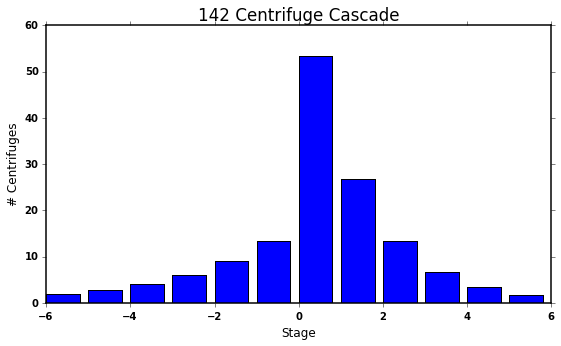

In [7]:
all_stages = np.array(strip_stages+enrich_stages)
n_centrifuges = np.sum(all_stages[:,1], axis=0)

bar_width = 0.8
bar_res = plt.bar(all_stages[:,0], all_stages[:,1], bar_width)

plt.xlabel('Stage')
plt.ylabel('# Centrifuges')
plt.title(str(int(n_centrifuges)) + " Centrifuge Cascade")
plt.legend()

plt.tight_layout()
plt.show()


Given the ideal cascade above, how does the product enrichment change with different feed enrichment?
How much new product is produced given the new feed rate?

In [8]:
Npc_mod = Npc_from_Nstages(alpha, Nfc_mod, n_stage_enr)
Nwc_mod = Nwc_from_Nstages(alpha, Nfc_mod, n_stage_str)

print "Cascade optimized for feed= ", Nfc
print "When used with feed= ", Nfc_mod, " product= ", Npc_mod, " tails= ", Nwc_mod 
print "NEnrich", n_stage_enr, " NStrip " , n_stage_str

Cascade optimized for feed=  0.0071
When used with feed=  0.2  product=  0.668337710858  tails=  0.0214343411132
NEnrich 6  NStrip  7


In [9]:
# starting feed stages and enrichment are starting cascade values
Nfs = Nfc_mod
Fs_mod = Fc_mod
print "stage, Feed,   Product,    N_F,     N_P"
enrich_stages = []
for i in range(1, n_stage_enr):  
    Nps = N_product_by_alpha(alpha, Nfs)
    Ps_mod = product_per_enr_stage(alpha, Nfs, Nps, Fs_mod)
    if (i == 1):
        W_enr1_mod = Fs_mod - Ps_mod
        Nw_enr1_mod = (Fs_mod*Nfs - Ps_mod*Nps)/W_enr1
    print i, Fs_mod, Ps_mod,  Nfs, Nps
    Nfs = Nps
    Fs_mod = Ps_mod
print "product of cascade (kg/mon)" , Fs_mod*60*60*24*30

stage, Feed,   Product,    N_F,     N_P
1 1.75134015595e-05 9.36586671517e-06 0.2 0.252032851115
2 9.36586671517e-06 5.09345894748e-06 0.252032851115 0.312317945819
3 5.09345894748e-06 2.82338850892e-06 0.312317945819 0.379702740019
4 2.82338850892e-06 1.59813871402e-06 0.379702740019 0.452068790845
5 1.59813871402e-06 9.24716930675e-07 0.452068790845 0.526519927924
product of cascade (kg/mon) 2.39686628431


In [10]:
F_strip_mod = W_enr1_mod
Nf_strip = Nw_enr1_mod

print "stage,    Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
for i in range(1, n_stage_str):  
    Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
    W_strip_mod = waste_per_strip_stage(alpha, Nf_strip, Nw_strip, F_strip_mod)
    strip_stages.append([-1*i,n_mach_s])
    print i, F_strip_mod, W_strip_mod, Nf_strip, Nw_strip
    F_strip_mod = W_strip_mod
    Nf_strip = Nw_strip
    
print "waste of cascade (kg/mon)" , W_strip_mod*60*60*24*30


stage,    Feed,    W_strip,   Nf_strip,   Nw_strip
1 8.14753484429e-06 5.46771091944e-06 0.0162520611606 0.0121087450076
2 5.46771091944e-06 3.67325381281e-06 0.0121087450076 0.00901205316493
3 3.67325381281e-06 2.46970082046e-06 0.00901205316493 0.00670193700693
4 2.46970082046e-06 1.66148792703e-06 0.00670193700693 0.0049810110129
5 1.66148792703e-06 1.11826105544e-06 0.0049810110129 0.00370033885293
6 1.11826105544e-06 7.52892386194e-07 0.00370033885293 0.00274803206079
waste of cascade (kg/mon) 1.95149706502


Design a Cascade For a Fixed Number of Centrifuges
(But need more info to determine whether to adjust feed rate or waste assay to reach target)

In [11]:
f_assay = 0.007
p_assay = 0.035
n_mach = 82

# Calculate the desired number of enrichment stages and machines per stage by ending
# the stages when there is less than an integer machine

enrich_stages = []
int_stages = True
n_stage_enr = 0
Fs = Fc
Nfs = f_assay
cur_mach_tot = 0
remain_mach = n_mach
print "stage, #mach, Feed,   Product,    N_F,     N_P"
while ((Nfs < p_assay) and (int_stages == True) and (int(remain_mach) > 0)):
    n_mach_enr = round(machines_per_enr_stage(alpha, del_U, Fs))
    # if the last stage doesn't have enough centrifuges then a compromise is needed
    # assume that machines are already operating at max possible feed rate, and 
    # so some of the product from stage N-1 will be siphoned off to reduce the total
    # feed into the last stage to be manageable. (this may not be a valid assumption)
#    remain_mach = n_mach - cur_mach_tot
    if (n_mach_enr >= remain_mach):
        Fs = allowed_feed_per_stage(alpha, del_U, remain_mach)
        cur_mach_tot += remain_mach
        int_stages = False
        cur_num = remain_mach
        remain_mach = 0
    else:
        remain_mach -= n_mach_enr
        cur_mach_tot += n_mach_enr
        cur_num = n_mach_enr
        
#    if (n_mach_enr <= 1):
#        int_stages = False
    Nps = N_product_by_alpha(alpha, Nfs)
    Ps = product_per_enr_stage(alpha, Nfs, Nps, Fs)
    print n_stage_enr, cur_num, Fs, Ps,  Nfs, Nps
    enrich_stages.append([n_stage_enr, n_mach_enr])
    if (n_stage_enr == 1):
        W_enr1 = Fs - Ps
        Nw_enr1 = (Fs*Nfs - Ps*Nps)/W_enr1
    Nfs = Nps
    Fs = Ps
    n_stage_enr+=1
if (Nps < p_assay):
    print "WARNING: Not enough centrifuges, Max achievable enrichment ", Nps
print "Total enriching machines ", cur_mach_tot, " Max enrich ", Nfs, "  Qty ", Fs


stage, #mach, Feed,   Product,    N_F,     N_P
0 53.0 0.000281356603314 0.000141020825068 0.007 0.00941188311913
1 27.0 0.000141020825068 7.07412439337e-05 0.00941188311913 0.012644210242
2 2.0 1.056e-05 5.30322152488e-06 0.012644210242 0.016967602529
Total enriching machines  82.0  Max enrich  0.016967602529   Qty  5.30322152488e-06


In [12]:
epsilon = alpha - 1.0
F_strip = W_enr1
Nf_strip = Nw_enr1

# Consider the zeroth stage of cascade to be on enrich side (iterate from 0), 
# then iterate from 1 for strip side
print "stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip"
strip_stages = []
int_stages = True
n_stage_str = 1
if (remain_mach > 0):
    while ((int_stages == True) and (int(remain_mach) > 0)):
#    if ((int_stages == True) and (int(remain_mach) > 0)):
        n_mach_s= round(machines_per_strip_stage(alpha, del_U, F_strip))
        # if the last stage doesn't have enough centrifuges then a compromise is needed
        # assume that machines are already operating at max possible feed rate, and 
        # so some of the product from stage N-1 will be siphoned off to reduce the total
        # feed into the last stage to be manageable. (this may not be a valid assumption)
        if (n_mach_s >= remain_mach) or (n_mach_s == 1):
            F_strip = allowed_feed_per_stage(alpha, del_U, remain_mach)
            cur_mach_tot += remain_mach
            int_stages = False
            cur_num = remain_mach
            remain_mach = 0
        else:
            cur_mach_tot += n_mach_s
            remain_mach -= n_mach_s
            cur_num = n_mach_s
        Nw_strip = N_waste_by_alpha(alpha, Nf_strip)
        W_strip = waste_per_strip_stage(alpha, Nf_strip, Nw_strip, F_strip)
        strip_stages.append([-1*n_stage_str,n_mach_s])
        print n_stage_str, n_mach_s, F_strip, W_strip, Nf_strip, Nw_strip
        F_strip = W_strip
        Nf_strip = Nw_strip
        n_stage_str+=1
else:
    print "Insufficent centrifuges to have a stripping section"
print "waste of cascade (kg/mon)" , W_strip*60*60*24*30, " assay is ", Nw_strip
print "Feed for strip ", F_strip

stage, #mach,       Feed,    W_strip,   Nf_strip,   Nw_strip
Insufficent centrifuges to have a stripping section
waste of cascade (kg/mon) 16.9754175402  assay is  0.00274803206079
Feed for strip  7.02795811345e-05
